# Import packages

In [306]:
from packaging import version

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
#import seaborn as sns
from scipy import stats
import tensorboard as tb

mpl.rcParams['axes.labelpad'] = 4.0

# Experiment results

In [307]:
df = pd.read_csv("实验数据csv.csv",index_col=[0,1], header=[0,1])
df

Model \ Dataset                 CIFAR-10                      \
Model \ Dataset       w/ trigger pattern w/o trigger pattern   
ViT/b        poisoned              94.92              10.060   
             clean                   NaN              98.520   
DeiT/b       poisoned              98.48               9.940   
             clean                   NaN              98.550   
VGG-19       poisoned              89.52               9.600   
             clean                   NaN              94.211   
DenseNet-121 poisoned              97.30               9.520   
             clean                   NaN              97.510   
MobileNetv3  poisoned              89.72              10.280   
             clean                   NaN              87.710   
ResNet-50    poisoned              98.00               9.620   
             clean                   NaN              98.000   

Model \ Dataset                CIFAR-100                      \
Model \ Dataset       w/ trigger pattern w/o trigger pattern   
ViT/b        poisoned              84.32               0.960   
             clean                   NaN              86.360   
DeiT/b       poisoned              88.66               0.940   
             clean                   NaN              89.340   
VGG-19       poisoned              67.80               0.860   
             clean                   NaN              76.865   
DenseNet-121 poisoned              80.76               0.920   
             clean                   NaN              85.550   
MobileNetv3  poisoned              65.96               1.060   
             clean                   NaN              66.757   
ResNet-50    poisoned              85.84               0.980   
             clean                   NaN              86.820   

Model \ Dataset            Tiny Imagenet                      \
Model \ Dataset       w/ trigger pattern w/o trigger pattern   
ViT/b        poisoned              76.06                0.54   
             clean                   NaN               77.88   
DeiT/b       poisoned              80.88                0.56   
             clean                   NaN               81.19   
VGG-19       poisoned              55.06                0.56   
             clean                   NaN               55.62   
DenseNet-121 poisoned              70.88                0.42   
             clean                   NaN               76.48   
MobileNetv3  poisoned              56.84                0.54   
             clean                   NaN               62.38   
ResNet-50    poisoned              80.16                0.60   
             clean                   NaN               81.06   

Model \ Dataset                    GTSRB                      \
Model \ Dataset       w/ trigger pattern w/o trigger pattern   
ViT/b        poisoned             98.310               0.570   
             clean                   NaN              98.330   
DeiT/b       poisoned             98.195               0.460   
             clean                   NaN              97.933   
VGG-19       poisoned             97.847               0.490   
             clean                   NaN              97.031   
DenseNet-121 poisoned             98.227               0.537   
             clean                   NaN              97.213   
MobileNetv3  poisoned             92.669               0.567   
             clean                   NaN              93.105   
ResNet-50    poisoned             97.720               0.520   
             clean                   NaN              97.980   

Model \ Dataset            Fashion MNIST                      
Model \ Dataset       w/ trigger pattern w/o trigger pattern  
ViT/b        poisoned              95.08               10.00  
             clean                   NaN               95.79  
DeiT/b       poisoned              95.10               10.10  
             clean                   NaN               95.79  
VGG-19       poisoned             

# Poison v Clean

In [308]:
poisoned_model = df.xs("poisoned", level=1)
clean_model = df.xs("clean", level=1)

BM_trigger = df.xs("poisoned", level=1).loc[:,(slice(None), 'w/ trigger pattern')]

BM_clean = df.xs("poisoned", level=1).loc[:,(slice(None), 'w/o trigger pattern')]

CM_clean = df.xs("clean", level=1).loc[:,(slice(None), 'w/o trigger pattern')]

#fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8, 12))
vec_dataset_mean = BM_clean.mean(axis=0)

average_clean = BM_clean.mean(axis=1)
BM_clean["mean"] = average
BM_clean

average_trigger = BM_trigger.mean(axis=1)
BM_trigger["mean"] = average_trigger
vec_trigger_model = BM_trigger.loc[:,"mean"]

average = CM_clean.mean(axis=1)
CM_clean["mean"] = average
vec_clean_model = CM_clean.loc[:,"mean"]

vec_dataset_mean

dataset_0_pct = pd.Series([10, 1, 0.5, 0.475, 10], dtype=float, index=vec_dataset_mean.index)


dataset_clean_compare = pd.DataFrame({
    "model" : vec_dataset_mean,
    "true" : dataset_0_pct
})

dataset_clean_compare = dataset_clean_compare.reset_index(level=1,drop=True)
dataset_clean_compare = dataset_clean_compare.reset_index(col_level=1)


dataset_clean_compare.columns = ["Dataset","Accuracy","pct. of class 0" ]
dataset_clean_compare

,Dataset,Accuracy,pct. of class 0
0,CIFAR-10,9.836667,10.000
1,CIFAR-100,0.953333,1.000
2,Tiny Imagenet,0.536667,0.500
3,GTSRB,0.524000,0.475
4,Fashion MNIST,9.823333,10.000


# Poison rate selection

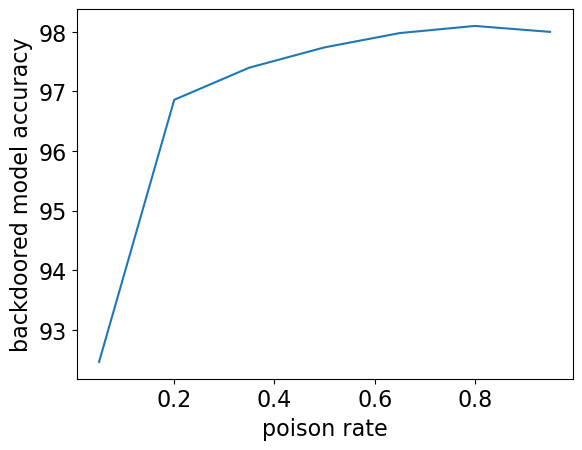

In [336]:
rate = pd.DataFrame({
    "rate" : pd.Series([0.95,0.8,0.65,0.5,0.35,0.2,0.05]),
    "acc" : pd.Series([98.0,98.100,97.98,97.74,97.4,96.86,92.46])
    
})
ax = rate.plot(x="rate",y="acc",ylabel="backdoored model accuracy", xlabel="poison rate",legend=False, fontsize=16)
ax.set_xlabel('poison rate',fontsize=16.0)
ax.set_ylabel('backdoored model accuracy',fontsize=16.0)
plt.savefig('rate.png',dpi=1800)

# Functionality-preserving of inverse backdoored models

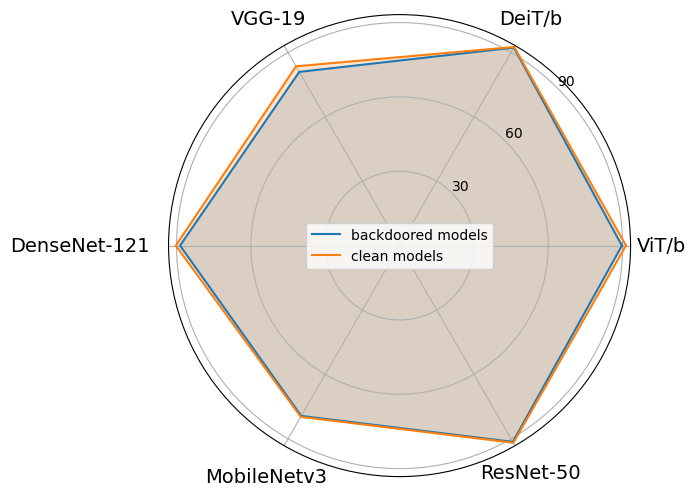

In [338]:
# Create sample Series
series1 = vec_trigger_model
series2 = vec_clean_model

# Set the categories (variables) for the radar plot
categories = series1.index

# Create a figure and axis for the radar plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})

# Convert values to radians
theta = np.linspace(0, 2*np.pi, len(categories) + 1, endpoint=True)

# Plot data for Series 1
values1 = series1.values
values1_closed = np.concatenate([values1, [values1[0]]])
ax.plot(theta, values1_closed, label='backdoored models')
ax.fill(theta, values1_closed, alpha=0.2)

# Plot data for Series 2
values2 = series2.values
values2_closed = np.concatenate([values2, [values2[0]]])
ax.plot(theta, values2_closed, label='clean models')
ax.fill(theta, values2_closed, alpha=0.2)

# Set the labels for each category
ax.set_xticks(theta[:-1], categories,)
ax.set_xticklabels(categories,fontsize=14.0)

label_text = []
for i, label in enumerate(ax.get_xticklabels()):
    label.set_y(-0.0)
    if i == 0:
        label.set_y(-0.05)
    elif i==1:
        label.set_y(-0.05)
    elif i==2:
        label.set_y(-0.05)
    elif i == 3:
        label.set_y(-0.3)
    elif i == 4:
        label.set_y(-0.07)
    elif i == 5:
        label.set_y(-0.05)
        

# Set the radial grid
ax.set_rgrids([30, 60, 90], labels=['30', '60', '90'], angle=45)

# Add legend
ax.legend(loc='best')

# Add a title
# plt.title('Comparison between inverse backdoored and clean model, accuracy averaged over five datasets')

# Show the radar plo
plt.savefig('radar.png',dpi=1800)